## Import libraries

In [31]:
from time import time
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
# from keras.applications.vgg16 import VGG16
from tensorflow.python.client import device_lib

# from keras.utils import plot_model
from keras.models import model_from_json
from keras.callbacks import TensorBoard

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10041174402353938126
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8186088918224680461
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

### Mount google drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Change the diractory to the cirrent working folder
os.chdir('/content/drive/MyDrive/DSAI_Project/Milestone4')
os.getcwd()

'/content/drive/MyDrive/DSAI_Project/Milestone4'

In [20]:
# Path to load the patch folder
train_data='./DATA/Train_aug'

In [21]:
# Function to define the phase (label) for each image
def label_encoder(img):
    label=img.split('.')[0]
    # print (label)
    if label=='aust':
        lb = 'Austenite'
    if label=='brain':
        lb = 'Bainite'
    if label=='ferr':
        lb = 'Ferrite'
    if label=='morten':
        lb = 'Martensite'
    if label=='parlite':
        lb = 'Pearlite'
    return lb

## DataLoader

In [22]:
def train_data_with_label():
    train_images=[]
    for i in tqdm(os.listdir(train_data)):
        path=os.path.join(train_data,i)
        # print(path)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(128,128))
        train_images.append([np.array(img),label_encoder(i)])
    shuffle(train_images)
    return train_images

In [23]:
training_images = train_data_with_label()
tr_lbl_data = np.array([i[1] for i in training_images])

100%|██████████| 3051/3051 [19:59<00:00,  2.54it/s]


### Ohe hot encoding
In this section the label in encoded like ohe hot encoder algorithm. Each phase is assigned to a different numpy array with binary number.

In [24]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
tr_encoded_lbl = ohe.fit_transform(tr_lbl_data.reshape(-1,1)).toarray()

In [25]:
tr_encoded_lbl

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [26]:
training_images[100]

[array([[1, 1, 7, ..., 0, 0, 0],
        [0, 0, 3, ..., 0, 0, 0],
        [0, 0, 3, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 7, 0],
        [0, 0, 0, ..., 0, 2, 0],
        [0, 0, 0, ..., 0, 0, 5]], dtype=uint8),
 'Pearlite']

In [27]:
tr_img_data = np.array([i[0] for i in training_images]).reshape(-1,128,128,1)#Flatten
tr_lbl_data = tr_encoded_lbl


## Train-test-split

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tr_img_data, tr_lbl_data, test_size=0.20,random_state=42)

In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2440, 128, 128, 1)
(2440, 5)
(611, 128, 128, 1)
(611, 5)


## Function to plot the loss and accuracy curve

In [30]:
from scipy.interpolate import make_interp_spline, BSpline
import pandas as pd

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1,figsize=(4.5,3))
    for l in loss_list:
        spl = make_interp_spline(epochs, history.history[l], k=3)
        xnew = np.linspace(1, 20, 40)
        y_smooth = spl(xnew)
        plt.plot(xnew, y_smooth, 'green', label='Train (' + str(str(format(history.history[l][-1],'.2f'))+')'))
        df = pd.DataFrame([history.history[l],y_smooth])#, columns=['Numbers'],columns=[0, 1]
        df = df.T
        # df.to_excel("train_loss_list_50_1.xlsx")
    for l in val_loss_list:
        spl = make_interp_spline(epochs, history.history[l], k=3)
        xnew = np.linspace(1, 20, 40)
        y_smooth = spl(xnew)
        plt.plot(xnew, y_smooth, '#9b3409', label='Validation (' + str(str(format(history.history[l][-1],'.2f'))+')'))
        df = pd.DataFrame([history.history[l],y_smooth])#, columns=['Numbers'],columns=[0, 1]
        df = df.T
        # df.to_excel("test_loss_list_50_1.xlsx")
    #plt.title('Loss')
    plt.xlabel('Epochs',fontsize=11)
    plt.ylabel('Loss',fontsize=11)
    plt.legend()
    # plt.savefig('error.png')

    ## Accuracy
    plt.figure(2,figsize=(4.5,3))
    for l in acc_list:
        spl = make_interp_spline(epochs, history.history[l], k=3)
        xnew = np.linspace(1, 20, 40)
        y_smooth = spl(xnew)
        plt.plot(xnew, y_smooth, 'green', label='Train (' + str(format(history.history[l][-1],'.2f'))+')')
        df = pd.DataFrame([history.history[l],y_smooth])#, columns=['Numbers'],columns=[0, 1]
        df = df.T
        # df.to_excel("train_acc_list_50_1.xlsx")
    for l in val_acc_list:
        spl = make_interp_spline(epochs, history.history[l], k = 3)  #define spline
        xnew = np.linspace(1, 20, 40)  #define epoch as 200 equally spaced values between the min and max of original epoch
        y_smooth = spl(xnew) #create smooth line chart
        plt.plot(xnew, y_smooth, '#9b3409', label='Validation (' + str(format(history.history[l][-1],'.2f'))+')')
        df = pd.DataFrame([history.history[l],y_smooth])#, columns=['Numbers'],columns=[0, 1]
        df = df.T
        # df.to_excel("test_acc_list_50_1.xlsx")


    #plt.title('Accuracy')
    plt.xlabel('Epochs',fontsize=11)
    plt.ylabel('Accuracy',fontsize=11)
    plt.legend(loc="lower right")
    # plt.savefig('accuracy.png')
    plt.show()


## Model Training using VGG19

In [ ]:
from keras.applications.vgg19 import VGG19
model = Sequential()
model.add(VGG19(include_top=False, weights=None,input_shape=(128,128,1)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.60))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='BinaryCrossentropy',
              optimizer=Adam(learning_rate=1e-2),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,023,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,220,613 (92.39 MB)

 Trainable params: 24,220,613 (92.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [ ]:
model_hist_vgg19 = model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32,validation_split=0.1,
          callbacks=[tensorboard],verbose=1,shuffle=True)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 69s 505ms/step - accuracy: 0.1966 - loss: 29844630929408.0000 - val_accuracy: 0.1882 - val_loss: 0.5042
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.1955 - loss: 0.5086 - val_accuracy: 0.1915 - val_loss: 0.5012
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.1985 - loss: 0.5043 - val_accuracy: 0.1915 - val_loss: 0.5008
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.2043 - loss: 0.5046 - val_accuracy: 0.2046 - val_loss: 0.5008
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.1995 - loss: 0.5045 - val_accuracy: 0.1882 - val_loss: 0.5014
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.2005 - loss: 0.5046 - val_accuracy: 0.2046 - val_loss: 0.5017
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.1905 - loss: 0.5033 - val_accuracy: 0.1915 - val_loss: 0.5012
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.1864 - loss: 0.50

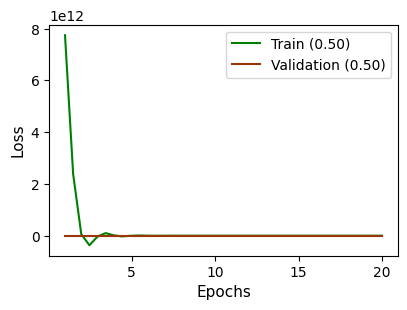

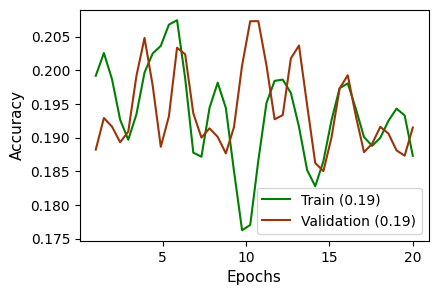

In [ ]:
plot_history(model_hist_vgg19)

## Resnet-50

In [32]:
from keras.applications.resnet import ResNet50
model = Sequential()
model.add(ResNet50(include_top=False, weights=None,input_shape=(128,128,1)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.60))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='BinaryCrossentropy',
              optimizer=Adam(learning_rate=1e-1),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,581,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,361,733 (153.97 MB)

 Trainable params: 40,308,613 (153.77 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [34]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [35]:
model_hist_res50 = model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32,validation_split=0.1,
          callbacks=[tensorboard],verbose=1,shuffle=True)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 99s 530ms/step - accuracy: 0.2347 - loss: 561.5601 - val_accuracy: 0.2029 - val_loss: 80195424.0000
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.2882 - loss: 0.5383 - val_accuracy: 0.2029 - val_loss: 5021.4531
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.2987 - loss: 0.4733 - val_accuracy: 0.1784 - val_loss: 712.8658
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.2579 - loss: 0.4818 - val_accuracy: 0.3322 - val_loss: 12.3776
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.3127 - loss: 0.4640 - val_accuracy: 0.2848 - val_loss: 0.8967
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.2941 - loss: 0.4713 - val_accuracy: 0.3191 - val_loss: 0.4642
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.3137 - loss: 0.4635 - val_accuracy: 0.3355 - val_loss: 0.4184
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.2969 - loss: 0.

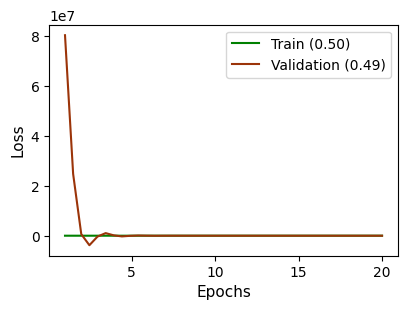

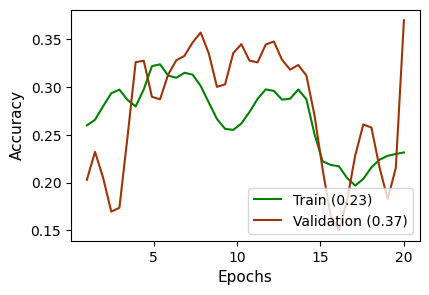

In [36]:
plot_history(model_hist_res50)

## EfficientNetB3

In [ ]:
from keras.applications.efficientnet import EfficientNetB3
model = Sequential()
model.add(EfficientNetB3(include_top=False, weights=None,input_shape=(128,128,1)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.60))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='BinaryCrossentropy',
              optimizer=Adam(learning_rate=1e-2),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 4, 4, 1536)     │    10,782,811 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    12,583,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,368,800 (89.14 MB)

 Trainable params: 23,281,501 (88.81 MB)

 Non-trainable params: 87,299 (341.02 KB)

In [ ]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [ ]:
model_hist_effb3 = model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32,validation_split=0.1,
          callbacks=[tensorboard],verbose=1,shuffle=True)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.2278 - loss: 6.8982 - val_accuracy: 0.2160 - val_loss: 28.3742
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.1993 - loss: 0.6942 - val_accuracy: 0.2046 - val_loss: 0.5131
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.2086 - loss: 0.5550 - val_accuracy: 0.1915 - val_loss: 0.5082
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.2010 - loss: 0.5120 - val_accuracy: 0.2062 - val_loss: 0.5030
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.1922 - loss: 0.5043 - val_accuracy: 0.1899 - val_loss: 0.5316
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.2036 - loss: 0.5007 - val_accuracy: 0.1948 - val_loss: 0.5317
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.2070 - loss: 0.5005 - val_accuracy: 0.1948 - val_loss: 0.5272
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.2006 - loss: 0.5004 - val_accuracy: 0.1

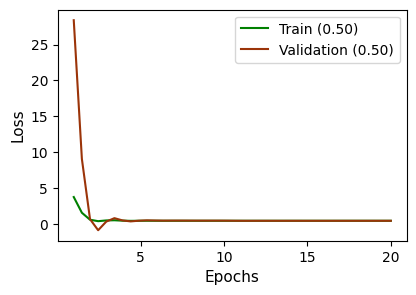

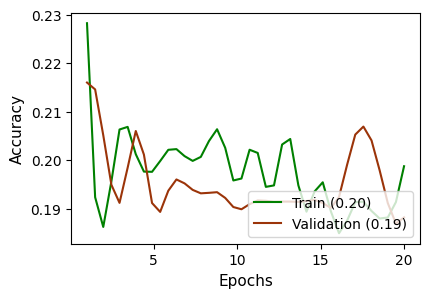

In [ ]:
plot_history(model_hist_effb3)

### Hyperparameter Tuning with Keras Tuner

To explore different hyperparameters for your ResNet50 model, you can use a hyperparameter tuning library like Keras Tuner. This library helps you automate the process of finding the best hyperparameters for your model.

Here's an example of how you can use Keras Tuner to tune the learning rate, dropout rate, and the number of units in the dense layer:

In [1]:
# # Install Keras Tuner
# !pip install keras-tuner

- Hyperparameter tuning was performed on local computer

In [ ]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(ResNet50(include_top=False, weights=None, input_shape=(128, 128, 1)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=256, max_value=1024, step=256), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.7, step=0.1)))
    model.add(Dense(5, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='BinaryCrossentropy',
        metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='resnet50_hptuner')

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal learning rate is {best_hps.get('learning_rate')}.
The optimal number of units in the dense layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout')}.
""")

# Build the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Best model accuracy: {accuracy}")

Trial 4 Complete [00h 03m 45s]
val_accuracy: 0.19148936867713928

Best val_accuracy So Far: 0.443535178899765
Total elapsed time: 00h 10m 52s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
1024              |768               |units
0.1               |0                 |dropout
0.0001            |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.2935 - loss: 1.6182

In [ ]:
# Get the top 10 models and their hyperparameters
top_n = 10
for i, hp in enumerate(tuner.get_best_hyperparameters(num_trials=top_n)):
    print(f"Trial {i+1}:")
    print(f"  Learning Rate: {hp.get('learning_rate')}")
    print(f"  Units: {hp.get('units')}")
    print(f"  Dropout: {hp.get('dropout')}")
    # You can also load and evaluate the model to get its performance metrics
    # model = tuner.get_best_models(num_models=top_n)[i]
    # loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    # print(f"  Test Accuracy: {accuracy}")

# To get a more detailed view of all trials:
tuner_results = tuner.get_best_trials(num_trials=100) # Get all trials up to 100

# Create a list to store the results
results_list = []
for trial in tuner_results:
    results_list.append({
        'learning_rate': trial.hyperparameters.get('learning_rate'),
        'units': trial.hyperparameters.get('units'),
        'dropout': trial.hyperparameters.get('dropout'),
        'score': trial.score # This is the objective metric (val_accuracy in this case)
    })

# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results_list)

# Display the DataFrame
display(results_df)

# You can now use this DataFrame to generate plots using libraries like matplotlib or seaborn
# For example, to plot score vs learning rate:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=results_df, x='learning_rate', y='score', hue='units', size='dropout')
# plt.title('Validation Accuracy vs Hyperparameters')
# plt.xlabel('Learning Rate')
# plt.ylabel('Validation Accuracy')
# plt.xscale('log') # Use log scale for learning rate
# plt.show()

NameError: name 'tuner' is not defined

## Regularization and early stopping

In [ ]:
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# Define the ResNet50 model with L2 regularization
model_reg = Sequential()
model_reg.add(ResNet50(include_top=False, weights=None, input_shape=(128, 128, 1)))
model_reg.add(Flatten())
model_reg.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_reg.add(Dropout(0.1))
model_reg.add(Dense(5, activation='softmax'))

# Compile the model
model_reg.compile(loss='BinaryCrossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with Early Stopping
model_hist_res50_reg = model_reg.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32,
                                   callbacks=[early_stopping, TensorBoard(log_dir="logs/resnet50_reg_{}".format(time()))],
                                   verbose=1, shuffle=True)

# Plot the training history
plot_history(model_hist_res50_reg)

NameError: name 'Sequential' is not defined

## k fold cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import clone_model

k = 4  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracy_per_fold = []
loss_per_fold = []
best_accuracy = 0
best_model = None

# K-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(kf.split(tr_img_data)):
    print(f'Fold {fold + 1}')

    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = tr_img_data[train_index], tr_img_data[val_index]
    y_train_fold, y_val_fold = tr_lbl_data[train_index], tr_lbl_data[val_index]

    # Define the model for this fold
    # You can define a new model here or use a function to build it
    # For example, using the build_model function from the hyperparameter tuning section:
    # model = build_model(best_hps) # If you want to use the best hyperparameters found

    # Or define a new model architecture if needed
    model_fold = Sequential()
    model_fold.add(ResNet50(include_top=False, weights=None, input_shape=(128, 128, 1)))
    model_fold.add(Flatten())
    model_fold.add(Dense(512, activation = 'relu'))
    model_fold.add(Dropout(0.60))
    model_fold.add(Dense(5, activation = 'softmax'))
    model_fold.compile(loss='BinaryCrossentropy',
                  optimizer=Adam(learning_rate=1e-2),
                  metrics=['accuracy'])


    # Train the model on the training fold
    history = model_fold.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model on the validation fold
    scores = model_fold.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold + 1}: {model_fold.metrics_names[0]} of {scores[0]}; {model_fold.metrics_names[1]} of {scores[1]*100:.2f}%')

    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Save the best performing model based on validation accuracy
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_model = clone_model(model_fold)
        best_model.set_weights(model_fold.get_weights())


# Calculate and print the average metrics across all folds
average_accuracy = np.mean(accuracy_per_fold)
average_loss = np.mean(loss_per_fold)
print(f'\nAverage Accuracy Across {k} Folds: {average_accuracy:.2f}%')
print(f'Average Loss Across {k} Folds: {average_loss:.4f}')

# Plot the results (optional, you can adapt this to your needs)
plt.figure(figsize=(10, 5))
plt.plot(range(1, k + 1), accuracy_per_fold, marker='o', linestyle='-')
plt.title('Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, k + 1))
plt.grid(True)
plt.show()

# Save the best model
if best_model:
    best_model.save('best_resnet50_kfold.h5')
    print("Best model saved as 'best_resnet50_kfold.h5'")